In [1]:
!pip install pretty-confusion-matrix
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attempting uninstall: pyflakes
    Found existing installation: pyflakes 2.4.0
    Uninstalling pyflakes-2.4.0:
      Successfully uninstalled pyflakes-2.4.0
  Attempting uninstall: pycodestyle
    Found existing installation: pycodestyle 2.8.0
    Uninstalling pycodestyle-2.8.0:
      Successfully uninstalled pycodestyle-2.8.0
  Attempting uninstall: flake8
    Fou

In [2]:
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from keras.layers import Bidirectional, Input, Dense, Layer, Dropout, LSTM, RepeatVector, Concatenate, Flatten
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K

In [4]:
print(tf.__version__)

2.6.4


In [5]:
### HYPERPARAMETERS
CONSTRUCTIVENESS_LEVELS = 5
POLITENESS_LEVELS = 3
EPOCHS = 20
MAXLEN = 768 # Since Embedding Layer returns 768 embeddings vector
LSTM_UNITS = 256
VOCAB_LEN = 1853
EMBEDDING_DIMENSION = 300

# FLAG
is_BiLSTM = True # Flag to automate other pre-processing for With or Without BiLSTM variants

# LABELS 
constructive_labels = ['HNC', 'NC', 'NN', 'C', 'HC']
politeness_labels = ['IMP', 'NP', 'P']

## ADD PATH OF THE PRE-TRAINED MODEL HERE ##
SAVE_PATH = "./WithoutAttention-Ablation-Model.h5" 

## SELECT THE EMBEDDING LAYER

In [6]:
## TOXIC-BERT
name = 'TOXIC-BERT'
embed_model_name = 'troesy/toxicBERT_3epoch'

# LOAD DATASET

In [7]:
# LOAD EMBEDS DATASET

def loadPickle(name):
    ## ADD YOUR BASE PATH TO OUR UR. EXAMPLE : ##
    # BASE_PATH = '../iitpolitenesslevels-DATASET/'
    BASE_PATH =''

    LOAD_PATH = BASE_PATH+name+'_train.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        train_embeds = pickle.load(handle)
        handle.close()

    LOAD_PATH = BASE_PATH+name+'_test.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        test_embeds = pickle.load(handle)
        handle.close()

    LOAD_PATH = BASE_PATH+name+'_val.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        val_embeds = pickle.load(handle)
        handle.close()

    y_train = pd.read_csv(BASE_PATH+'y_train.csv')
    y_val = pd.read_csv(BASE_PATH+'y_val.csv')
    y_test = pd.read_csv(BASE_PATH+'y_test.csv')

    print('\n***** LOADED '+ name+' *****\n')
    print(f'TRAIN SHAPE : {train_embeds.shape}\nTEST SHAPE : {test_embeds.shape}\nVAL SHAPE : {val_embeds.shape}\nY-TRAIN SHAPE : {y_train.shape}\nY-TEST SHAPE : {y_test.shape}\nY-VAL SHAPE : {y_val.shape}')

    return train_embeds, test_embeds, val_embeds, y_train, y_test, y_val

In [8]:
train_embeds, test_embeds, val_embeds, y_train, y_test, y_val = loadPickle(name)

2022-12-26 16:22:40.199458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 16:22:40.200951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 16:22:40.353493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 16:22:40.354871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 16:22:40.356112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S


***** LOADED TOXIC-BERT *****

TRAIN SHAPE : (4224, 1, 768)
TEST SHAPE : (792, 1, 768)
VAL SHAPE : (264, 1, 768)
Y-TRAIN SHAPE : (4224, 8)
Y-TEST SHAPE : (792, 8)
Y-VAL SHAPE : (264, 8)


2022-12-26 16:22:40.361058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 16:22:40.686375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 16:22:40.687566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 16:22:40.688810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
y_train.head()

,HNC,NC,NN,C,HC,IMP,NP,P
0,0,0,0,0,1,0,0,1
1,0,0,0,0,1,0,1,0
2,0,1,0,0,0,1,0,0
3,0,0,0,1,0,1,0,0
4,1,0,0,0,0,1,0,0


### LOAD EMBEDDING MODEL

In [10]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [11]:
if not is_BiLSTM:
    tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
    embed_model = AutoModel.from_pretrained(embed_model_name)

In [12]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# SAMPLE 
if not is_BiLSTM:
    sent = ['This work studies the predictive uncertainty issue of deep learning models.']
    outputs = sent2embed(embed_model, sent)
    outputs[1].shape


In [13]:
# PRE-PROCESS
def Embed(reviews, y_train, model):
    embed_arr = []
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(model, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])

    embed_train_arr = tf.stack(embed_arr)

    return embed_train_arr, y_train

# MODEL

### ATTENTION LAYER

In [14]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences , 
        })
        return config


    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a
        
        return K.sum(output, axis=1) 

In [15]:
if not is_BiLSTM:
    ## ONLY IF BiLSTM NOT there -- REDUCE DIMENSION OF DATASET BY 1DIM 
    train_embeds = np.array([row[0] for row in train_embeds ])
    test_embeds = np.array([row[0] for row in test_embeds ])
    val_embeds = np.array([row[0] for row in val_embeds ])


## DEFINE MODELS

Comment the appropriate layers and update the inputs to the layers accordingly to make the ablation variant. 

<b>Note:</b> Donot forget to update `is_BiLSTM` variable at the top if you are commenting or uncommenting the BiLSTM layer. 

Seen below is Without-Attention ablation variant

In [16]:
embed = Input(shape = (None, MAXLEN), name='INPUT') # with BiLSTM
# embed = Input(shape=  (MAXLEN,), name='INPUT') # without BiLSTM

biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
# repeat_op = RepeatVector(1)(biLSTM)

# __________________ #

## ATTENTION 
# attentions=[]
# for i in range(CONSTRUCTIVENESS_LEVELS):
#   x = Attention(return_sequences=False)(repeat_op)
#   attentions.append(x)

# concate_attention  = Concatenate()(attentions)
# flatten = Flatten()(concate_attention)


# __________________ #

# BRANCH 1
b1_x =  Dense(2*MAXLEN, activation='relu', name='CONSTRUCTIVENESS_DENSE')(biLSTM)
b1_x = Dropout(0.2)(b1_x)
b1_x =  Dense(MAXLEN, activation='relu', name='CONSTRUCTIVENESS_DENSE_1')(b1_x)
b1_x = Dropout(0.2)(b1_x)
category_output = Dense(CONSTRUCTIVENESS_LEVELS, activation='softmax', name='CONSTRUCTIVENESS_OUTPUT')(b1_x)

# __________________ #

# BRANCH 2
b2_x =  Dense(2*MAXLEN, activation='relu', name='POLITENESS_DENSE')(biLSTM)
b2_x = Dropout(0.2)(b2_x)
b2_x =  Dense(MAXLEN, activation='relu', name='POLITENESS_DENSE_1')(b2_x)
b2_x = Dropout(0.2)(b2_x)
polarity_output = Dense(POLITENESS_LEVELS, activation='softmax', name='POLITENESS_OUTPUT')(b2_x)

model = Model(inputs=embed, outputs=[category_output, polarity_output])

## COMPILE MODEL

In [17]:
metrics =[ 
    'accuracy', 
    tf.keras.metrics.Precision(), 
    tf.keras.metrics.Recall()
]

loss = { 'CONSTRUCTIVENESS_OUTPUT': 'categorical_crossentropy', 
        'POLITENESS_OUTPUT': 'categorical_crossentropy'
       }

lossWeights = { 'CONSTRUCTIVENESS_OUTPUT': 1.0, 
               'POLITENESS_OUTPUT': 1.0
              }


model.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam', 
                        metrics=['accuracy']) 


model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, None, 768)]  0                                            
__________________________________________________________________________________________________
BILSTM (Bidirectional)          (None, 512)          2099200     INPUT[0][0]                      
__________________________________________________________________________________________________
CONSTRUCTIVENESS_DENSE (Dense)  (None, 1536)         787968      BILSTM[0][0]                     
__________________________________________________________________________________________________
POLITENESS_DENSE (Dense)        (None, 1536)         787968      BILSTM[0][0]                     
______________________________________________________________________________________________

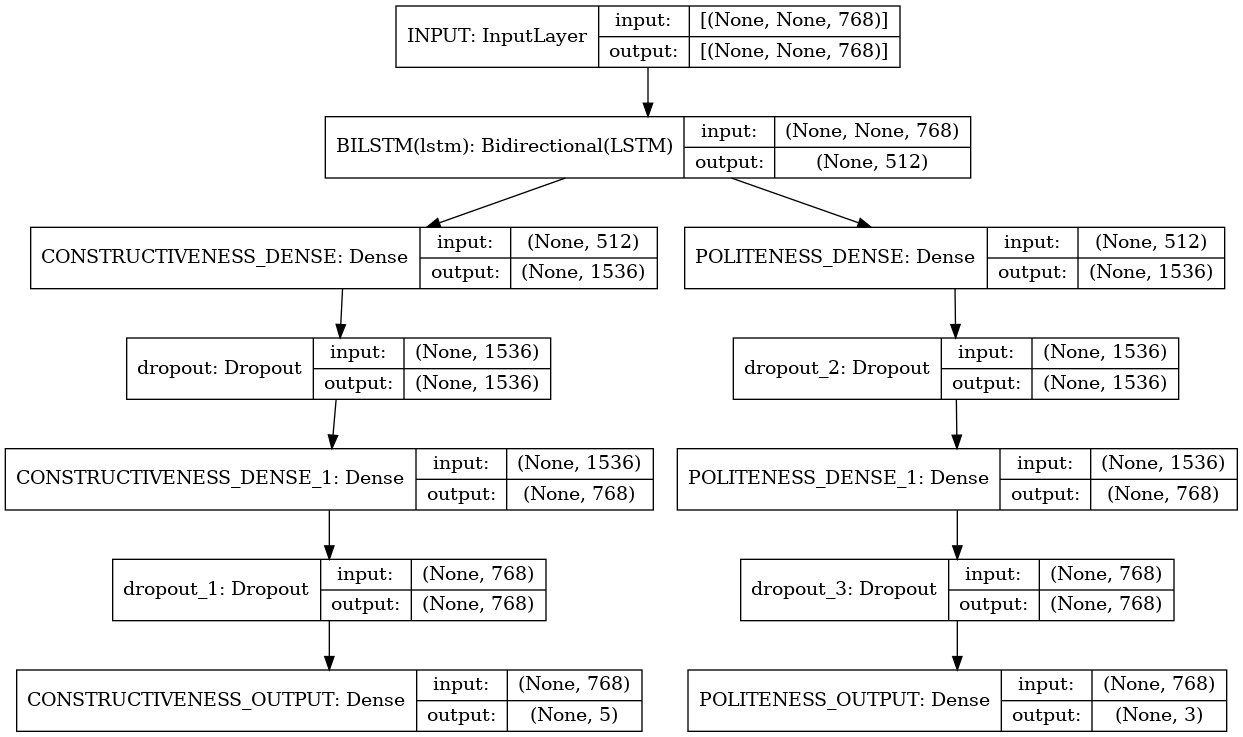

In [18]:
tf.keras.utils.plot_model(model, to_file='multi-task_model.png', show_shapes=True)

## TRAIN MODEL

In [19]:
history = model.fit(train_embeds, 
                    y =  {
                          'CONSTRUCTIVENESS_OUTPUT': y_train[constructive_labels].values, 
                          'POLITENESS_OUTPUT': y_train[politeness_labels].values
                          },  
                           validation_data = (test_embeds, {
                          'CONSTRUCTIVENESS_OUTPUT': y_test[constructive_labels].values, 
                          'POLITENESS_OUTPUT': y_test[politeness_labels].values
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2
                )


2022-12-26 16:22:54.409416: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-12-26 16:22:58.402831: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


132/132 - 8s - loss: 2.0453 - CONSTRUCTIVENESS_OUTPUT_loss: 1.1746 - POLITENESS_OUTPUT_loss: 0.8707 - CONSTRUCTIVENESS_OUTPUT_accuracy: 0.4896 - POLITENESS_OUTPUT_accuracy: 0.5840 - val_loss: 1.8247 - val_CONSTRUCTIVENESS_OUTPUT_loss: 1.0320 - val_POLITENESS_OUTPUT_loss: 0.7927 - val_CONSTRUCTIVENESS_OUTPUT_accuracy: 0.5290 - val_POLITENESS_OUTPUT_accuracy: 0.6528
Epoch 2/20
132/132 - 1s - loss: 1.7313 - CONSTRUCTIVENESS_OUTPUT_loss: 0.9799 - POLITENESS_OUTPUT_loss: 0.7514 - CONSTRUCTIVENESS_OUTPUT_accuracy: 0.5909 - POLITENESS_OUTPUT_accuracy: 0.6567 - val_loss: 1.6612 - val_CONSTRUCTIVENESS_OUTPUT_loss: 0.9305 - val_POLITENESS_OUTPUT_loss: 0.7307 - val_CONSTRUCTIVENESS_OUTPUT_accuracy: 0.6301 - val_POLITENESS_OUTPUT_accuracy: 0.6654
Epoch 3/20
132/132 - 1s - loss: 1.4903 - CONSTRUCTIVENESS_OUTPUT_loss: 0.8270 - POLITENESS_OUTPUT_loss: 0.6633 - CONSTRUCTIVENESS_OUTPUT_accuracy: 0.6660 - POLITENESS_OUTPUT_accuracy: 0.7095 - val_loss: 1.4201 - val_CONSTRUCTIVENESS_OUTPUT_loss: 0.7888 - 

In [20]:
# SAVE MODEL
SAVE_PATH = './Politeness_'+name+'.h5'
model.save(SAVE_PATH, overwrite=True, save_format="tf")
print("Weights Saved")

Weights Saved


In [21]:
# LOAD MODEL
from keras.models import load_model
LOAD_PATH = SAVE_PATH
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

model.evaluate(test_embeds,[ y_test[constructive_labels].values, y_test[politeness_labels].values] )



MODEL LOADED


25/25 [==============================] - 1s 5ms/step - loss: 1.1330 - CONSTRUCTIVENESS_OUTPUT_loss: 0.5967 - POLITENESS_OUTPUT_loss: 0.5363 - CONSTRUCTIVENESS_OUTPUT_accuracy: 0.8889 - POLITENESS_OUTPUT_accuracy: 0.9091


[1.1330292224884033,
 0.5967034101486206,
 0.5363258123397827,
 0.8888888955116272,
 0.9090909361839294]

## ANALYSIS

In [22]:
history.history.keys()

dict_keys(['loss', 'CONSTRUCTIVENESS_OUTPUT_loss', 'POLITENESS_OUTPUT_loss', 'CONSTRUCTIVENESS_OUTPUT_accuracy', 'POLITENESS_OUTPUT_accuracy', 'val_loss', 'val_CONSTRUCTIVENESS_OUTPUT_loss', 'val_POLITENESS_OUTPUT_loss', 'val_CONSTRUCTIVENESS_OUTPUT_accuracy', 'val_POLITENESS_OUTPUT_accuracy'])

## VALIDATION

In [23]:
metrics_keys = list(history.history.keys())

loss = history.history[metrics_keys[0]]
CONSTRUCTIVENESS_OUTPUT_loss = history.history[metrics_keys[1]]
POLITENESS_OUTPUT_loss = history.history[metrics_keys[2]]
CONSTRUCTIVENESS_OUTPUT_accuracy = history.history[metrics_keys[3]]
POLITENESS_OUTPUT_accuracy = history.history[metrics_keys[4]]
val_loss = history.history[metrics_keys[5]]
val_CONSTRUCTIVENESS_OUTPUT_loss = history.history[metrics_keys[6]]
val_POLITENESS_OUTPUT_loss = history.history[metrics_keys[7]]
val_CONSTRUCTIVENESS_OUTPUT_accuracy = history.history[metrics_keys[8]]
val_POLITENESS_OUTPUT_accuracy = history.history[metrics_keys[9]]



print("\nCONSTRUCTIVENESS ACCURACY : " , CONSTRUCTIVENESS_OUTPUT_accuracy)
print("\nPOLITENESS ACCURACY : " , POLITENESS_OUTPUT_accuracy)
print("\nVAL CONSTRUCTIVENESS ACCURACY : " ,val_CONSTRUCTIVENESS_OUTPUT_accuracy)
print("\nVAL POLITENESS ACCURACY : " ,val_POLITENESS_OUTPUT_accuracy)

print("\nLOSS : " , loss)
print("\nVAL LOSS : " , val_loss)
print("\nCONSTRUCTIVENESS LOSS : " , CONSTRUCTIVENESS_OUTPUT_loss)
print("\nCONSTRUCTIVENESS VAL LOSS : " , val_CONSTRUCTIVENESS_OUTPUT_loss)
print("\nPOLITENESS LOSS : " , POLITENESS_OUTPUT_loss)
print("\nPOLITENESS VAL LOSS : " , val_POLITENESS_OUTPUT_loss)


CONSTRUCTIVENESS ACCURACY :  [0.4895833432674408, 0.5909090638160706, 0.665956437587738, 0.7189867496490479, 0.7616003751754761, 0.8108428120613098, 0.8409090638160706, 0.8764204382896423, 0.8813920617103577, 0.9095643758773804, 0.9124053120613098, 0.9391571879386902, 0.9337121248245239, 0.9405776262283325, 0.9441288113594055, 0.9597538113594055, 0.9566761255264282, 0.9618844985961914, 0.9602272510528564, 0.9644886255264282]

POLITENESS ACCURACY :  [0.584043562412262, 0.6567234992980957, 0.7095170617103577, 0.7554450631141663, 0.7881155014038086, 0.8307291865348816, 0.857481062412262, 0.884706437587738, 0.8984375, 0.9157196879386902, 0.9249526262283325, 0.9469696879386902, 0.9514678120613098, 0.9599905014038086, 0.9614109992980957, 0.9618844985961914, 0.9566761255264282, 0.974668562412262, 0.9718276262283325, 0.9770359992980957]

VAL CONSTRUCTIVENESS ACCURACY :  [0.5290403962135315, 0.6300504803657532, 0.6944444179534912, 0.7121211886405945, 0.6666666865348816, 0.747474730014801, 0.76

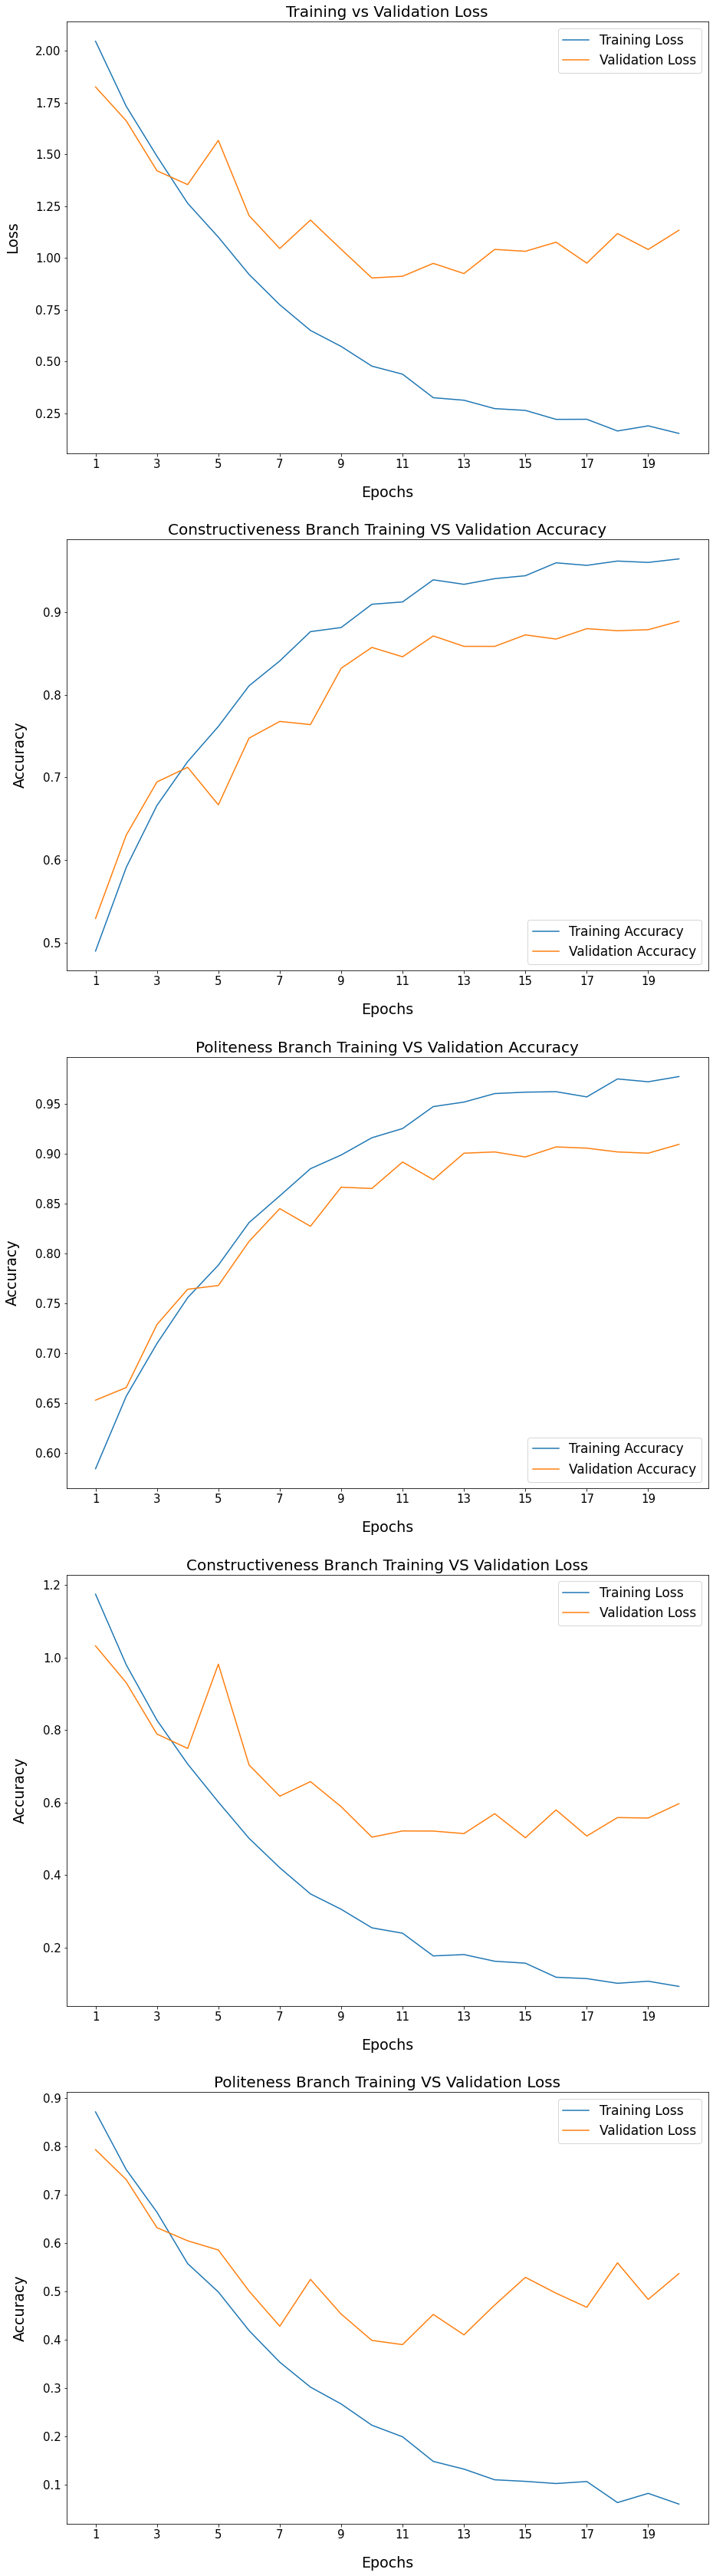

In [24]:
metrics = history.history['loss']
epochs_range = range(1, len(metrics) + 1) 
xticks = range(1, len(metrics) + 1, 2)

plt.figure(figsize=(15, 60))

# Train vs Val Loss 
plt.subplot(5, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Loss', fontsize=19, labelpad=20)
plt.xticks(xticks)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17, loc='upper right')


# CONSTRUCTIVENESS Train vs Val Acc
plt.subplot(5, 1, 2)
plt.plot(epochs_range, CONSTRUCTIVENESS_OUTPUT_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_CONSTRUCTIVENESS_OUTPUT_accuracy, label='Validation Accuracy')
plt.title('Constructiveness Branch Training VS Validation Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.xticks(xticks)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='lower right')


# POLITENESS Train vs Val Acc
plt.subplot(5, 1, 3)
plt.plot(epochs_range, POLITENESS_OUTPUT_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_POLITENESS_OUTPUT_accuracy, label='Validation Accuracy')
plt.title('Politeness Branch Training VS Validation Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.xticks(xticks)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='lower right')


# CONSTRUCTIVENESS Train vs Val Loss
plt.subplot(5, 1, 4)
plt.plot(epochs_range, CONSTRUCTIVENESS_OUTPUT_loss, label='Training Loss')
plt.plot(epochs_range, val_CONSTRUCTIVENESS_OUTPUT_loss, label='Validation Loss')
plt.title('Constructiveness Branch Training VS Validation Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.xticks(xticks)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='upper right')


# POLITENESS Train vs Val Loss
plt.subplot(5, 1, 5)
plt.plot(epochs_range, POLITENESS_OUTPUT_loss, label='Training Loss')
plt.plot(epochs_range, val_POLITENESS_OUTPUT_loss, label='Validation Loss')
plt.title('Politeness Branch Training VS Validation Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.xticks(xticks)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='upper right')

plt.show()

In [25]:
# POLITENESS

## TEST
y_pred_test = model.predict(test_embeds)
y_pred_test_cons_idx = np.argmax(y_pred_test[0], axis=1)
y_pred_test_pol_idx = np.argmax(y_pred_test[1], axis=1)

y_test_true_cons_idx =np.argmax(y_test[constructive_labels].values, axis=1)
y_test_true_pol_idx =np.argmax(y_test[politeness_labels].values, axis=1)


## VAL
y_pred_val = model.predict(val_embeds)
y_pred_val_cons_idx = np.argmax(y_pred_val[0], axis=1)
y_pred_val_pol_idx = np.argmax(y_pred_val[1], axis=1)

y_val_true_cons_idx =np.argmax(y_val[constructive_labels].values, axis=1)
y_val_true_pol_idx =np.argmax(y_val[politeness_labels].values, axis=1 )

In [26]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

# CONSTRUCTIVENESS
cm_cons_test = cm(y_test_true_cons_idx, y_pred_test_cons_idx)
cm_cons_val = cm(y_val_true_cons_idx, y_pred_val_cons_idx)

# POLITENESS
cm_pol_test = cm(y_test_true_pol_idx, y_pred_test_pol_idx)
cm_pol_val = cm(y_val_true_pol_idx, y_pred_val_pol_idx)

In [27]:
# CLASS-WISE ACCURACY

## CONSTRUCTIVENESS
cm_cons_test_acc = cm_cons_test.astype('float') / cm_cons_test.sum(axis=1)[:, np.newaxis]
cm_cons_test_acc =cm_cons_test_acc.diagonal()

cm_cons_val_acc = cm_cons_val.astype('float') / cm_cons_val.sum(axis=1)[:, np.newaxis]
cm_cons_val_acc =cm_cons_val_acc.diagonal()

## POLITENESS ACCURACY
cm_pol_test_acc = cm_pol_test.astype('float') / cm_pol_test.sum(axis=1)[:, np.newaxis]
cm_pol_test_acc =cm_pol_test_acc.diagonal()

cm_pol_val_acc = cm_pol_val.astype('float') / cm_pol_val.sum(axis=1)[:, np.newaxis]
cm_pol_val_acc =cm_pol_val_acc.diagonal()


# ------------------------ #

# TEST
print('*** CLASS-WISE  TEST ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(constructive_labels, cm_cons_test_acc):
    print('',cat,"\t",round(acc, 3)) 
    
print("\nCLASS\tACCURACY")
for cat, acc in zip(politeness_labels, cm_pol_test_acc):
    print('',cat,"\t",round(acc, 3))

# ------------------------ #

# VAL    

print('\n\n*** CLASS-WISE  VAL ACCURACY : **** \n')
print("\nCLASS\tACCURACY")
for cat, acc in zip(constructive_labels, cm_cons_val_acc):
    print('',cat,"\t",round(acc, 3))
    
print("CLASS\tACCURACY")
for cat, acc in zip(politeness_labels, cm_pol_val_acc):
    print('',cat,"\t",round(acc, 3))
    

*** CLASS-WISE  TEST ACCURACY : **** 

CLASS	ACCURACY
 HNC 	 0.987
 NC 	 0.824
 NN 	 0.748
 C 	 0.913
 HC 	 0.987

CLASS	ACCURACY
 IMP 	 0.953
 NP 	 0.861
 P 	 0.919


*** CLASS-WISE  VAL ACCURACY : **** 


CLASS	ACCURACY
 HNC 	 1.0
 NC 	 0.76
 NN 	 0.745
 C 	 0.792
 HC 	 1.0
CLASS	ACCURACY
 IMP 	 0.956
 NP 	 0.79
 P 	 0.913


In [28]:
def plotHeatmap(cm, branch, data_type, labels):
    plt.figure(figsize=(25, 10))
    sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=labels, xticklabels=labels)
    plt.xlabel('Predicted Values', fontsize=20, labelpad=20)
    plt.ylabel('Actual Values', fontsize=20, labelpad=20)
    title = branch+' Confusion Matrix for '+data_type+' Data'
    plt.title(title, fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

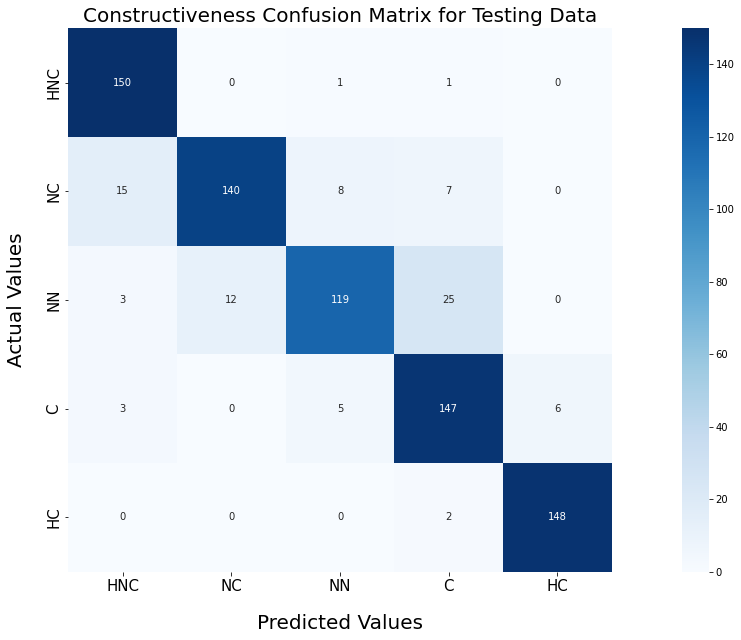

In [29]:
plotHeatmap(cm_cons_test, 'Constructiveness', 'Testing', constructive_labels)

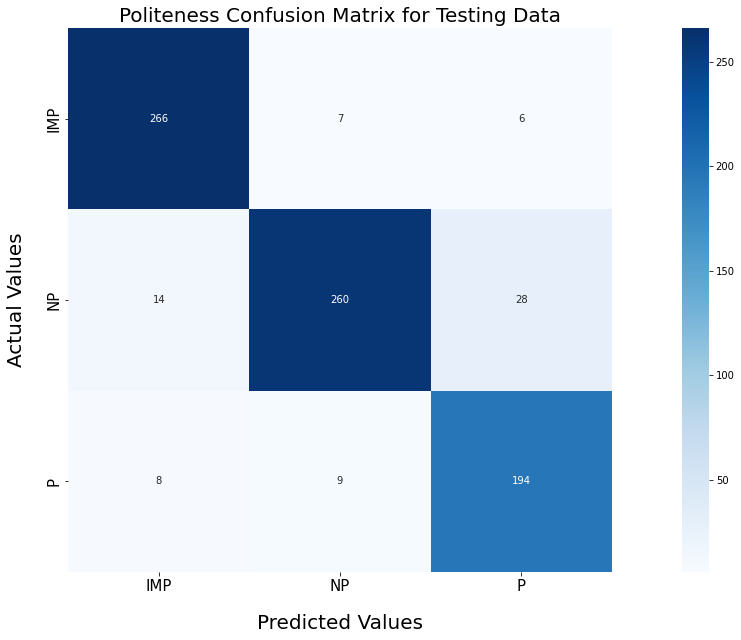

In [30]:
plotHeatmap(cm_pol_test, 'Politeness', 'Testing', politeness_labels)

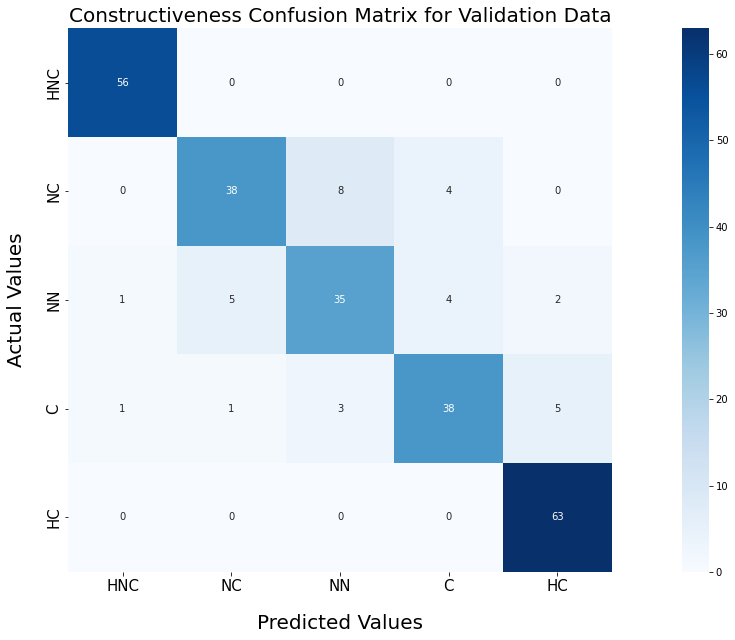

In [31]:
plotHeatmap(cm_cons_val, 'Constructiveness', 'Validation', constructive_labels)

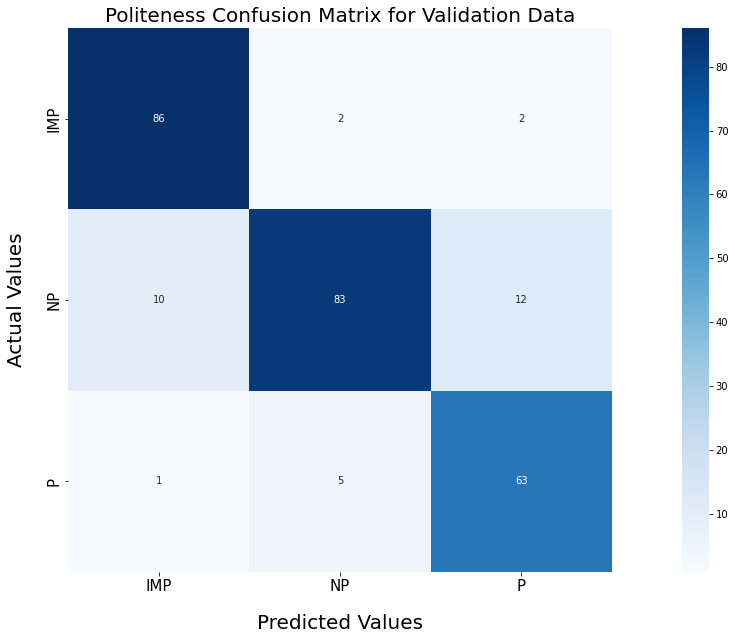

In [32]:
plotHeatmap(cm_pol_val, 'Politeness', 'Validation', politeness_labels)

--------------

In [33]:
from pretty_confusion_matrix import pp_matrix

def customCM(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    cmap = 'PuRd'
    pp_matrix(df_cm, cmap=cmap)

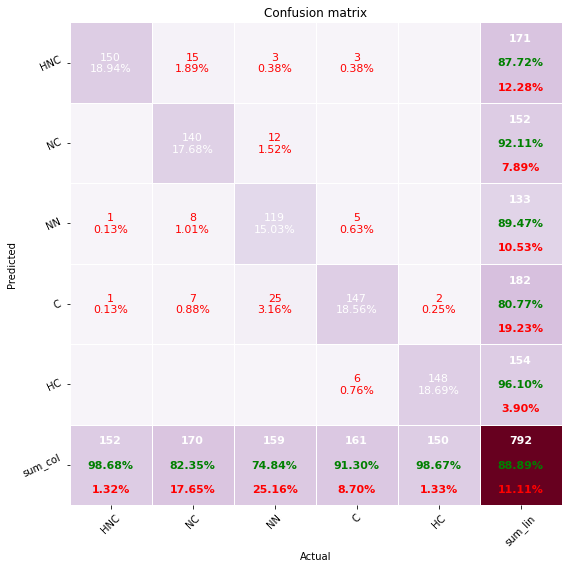

In [34]:
customCM(cm_cons_test, constructive_labels)

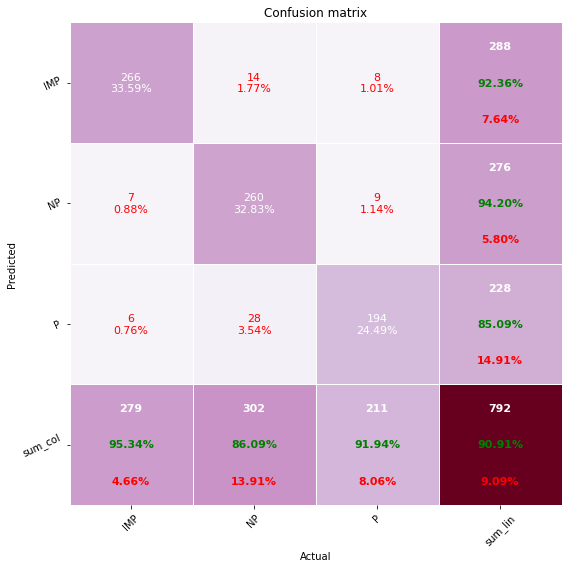

In [35]:
customCM(cm_pol_test, politeness_labels)

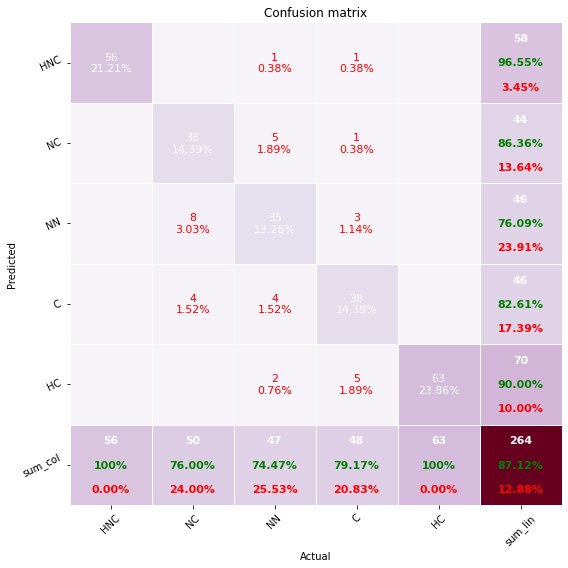

In [36]:
customCM(cm_cons_val, constructive_labels)

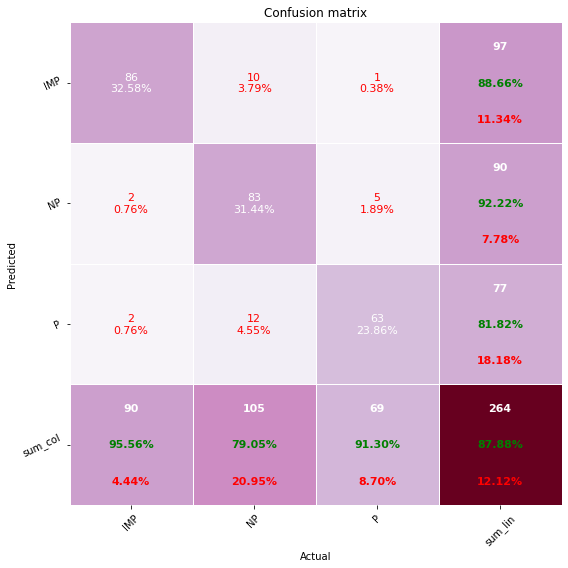

In [37]:
customCM(cm_pol_val, politeness_labels)

In [38]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report

def class_report(y_test_true_idx, y_pred_test_idx,y_val_true_idx, y_pred_val_idx , labels):
    print('\n\n**** TESTING ****\n\n', classification_report(y_test_true_idx, y_pred_test_idx, target_names=labels))
    print('\n\n**** VALIDATION ****\n\n',classification_report(y_val_true_idx, y_pred_val_idx , target_names=labels))

In [39]:
class_report(y_test_true_pol_idx, y_pred_test_pol_idx, y_val_true_pol_idx, y_pred_val_pol_idx , politeness_labels)



**** TESTING ****

               precision    recall  f1-score   support

         IMP       0.92      0.95      0.94       279
          NP       0.94      0.86      0.90       302
           P       0.85      0.92      0.88       211

    accuracy                           0.91       792
   macro avg       0.91      0.91      0.91       792
weighted avg       0.91      0.91      0.91       792



**** VALIDATION ****

               precision    recall  f1-score   support

         IMP       0.89      0.96      0.92        90
          NP       0.92      0.79      0.85       105
           P       0.82      0.91      0.86        69

    accuracy                           0.88       264
   macro avg       0.88      0.89      0.88       264
weighted avg       0.88      0.88      0.88       264



In [40]:
class_report(y_test_true_cons_idx, y_pred_test_cons_idx, y_val_true_cons_idx, y_pred_val_cons_idx , constructive_labels)



**** TESTING ****

               precision    recall  f1-score   support

         HNC       0.88      0.99      0.93       152
          NC       0.92      0.82      0.87       170
          NN       0.89      0.75      0.82       159
           C       0.81      0.91      0.86       161
          HC       0.96      0.99      0.97       150

    accuracy                           0.89       792
   macro avg       0.89      0.89      0.89       792
weighted avg       0.89      0.89      0.89       792



**** VALIDATION ****

               precision    recall  f1-score   support

         HNC       0.97      1.00      0.98        56
          NC       0.86      0.76      0.81        50
          NN       0.76      0.74      0.75        47
           C       0.83      0.79      0.81        48
          HC       0.90      1.00      0.95        63

    accuracy                           0.87       264
   macro avg       0.86      0.86      0.86       264
weighted avg       0.87      0